In [23]:
import numpy as np
import matplotlib.pyplot as plt
from models.unet import UNET, make_Jaccard_XEntropy_Loss
from data.make_dataset import load_train_images
from keras_contrib.losses.jaccard import jaccard_distance
from sklearn.utils.class_weight import compute_class_weight
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.optimizers import Adam

In [2]:
train, val, y_train, y_val = load_train_images()

In [3]:
_, height, width, channel = train.shape
input_shape = (height, width, channel)

In [42]:
unet = UNET(input_shape,3,[4,8,16,32],3)

In [43]:
unet.model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 256, 256, 4)  40          input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 256, 256, 4)  148         conv2d_39[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 128, 128, 4)  0           conv2d_40[0][0]                  
____________________________________________________________________________________________

In [6]:
jaccard_xentropy = make_Jaccard_XEntropy_Loss(0.9)

In [41]:
class_weights = compute_class_weight('balanced',np.unique(y_train),y_train.flatten())
class_weights

array([ 0.35621142, 16.19044074,  7.63862767])

In [44]:
unet.model.compile(optimizer=Adam(lr=1e-4),loss=jaccard_xentropy,metrics=[jaccard_distance, 'accuracy'])

In [45]:
# we create two instances with the same arguments
data_gen_args = dict(rotation_range=45,
                     zoom_range=0.2,
                     fill_mode='reflect')
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 42
image_generator = image_datagen.flow(train,batch_size=1,seed=42)

mask_generator = mask_datagen.flow(to_categorical(y_train,3),batch_size=1,seed=42)

# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

In [ ]:
for x_batch, y_batch in train_generator:
    plt.subplot(1,2,1)
    plt.imshow(x_batch[0,:,:,0])
    plt.subplot(1,2,2)
    plt.imshow(y_batch[0,:,:,0])
    plt.show()
    import pdb; pdb.set_trace()

In [47]:
unet.model.fit_generator(train_generator,steps_per_epoch=len(train),epochs=2,shuffle=True,validation_data=(val,to_categorical(y_val,3)),workers=4,class_weight=class_weights)

Epoch 1/2
669/669 [==============================] - 131s 196ms/step - loss: 0.3573 - jaccard_distance: 0.2472 - accuracy: 0.8796 - val_loss: 0.2114 - val_jaccard_distance: 0.1228 - val_accuracy: 0.9374
Epoch 2/2
669/669 [==============================] - 130s 195ms/step - loss: 0.2209 - jaccard_distance: 0.1283 - accuracy: 0.9346 - val_loss: 0.2114 - val_jaccard_distance: 0.1228 - val_accuracy: 0.9374


In [48]:
preds = unet.model.predict(val,verbose=1)

173/173 [==============================] - 4s 25ms/step


In [49]:
preds.shape

(173, 256, 256, 3)

In [50]:
preds = preds.argmax(-1)

In [51]:
preds.shape

(173, 256, 256)

In [52]:
uniq, counts = np.unique(preds, return_counts=True)

In [53]:
counts/counts.sum()

array([1.])

In [54]:
uniq

array([0])

In [35]:
uniq, counts = np.unique(y_val, return_counts=True)

In [36]:
counts/counts.sum()

array([0.93738975, 0.01963868, 0.04297157])

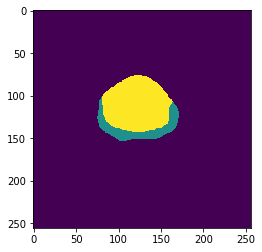

In [39]:
plt.imshow(y_val[12,:,:,0])

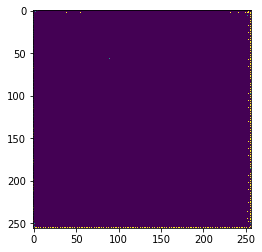

In [40]:
plt.imshow(preds[12,:,:])

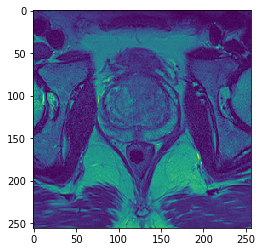

In [21]:
plt.imshow(val[11,:,:,0])